# Build Databases

The first thing we need to do is get the data into a form that we can draw upon to assemble training and test data for pout learning algorithm. The data is stored in a multitude of files in various formats. Some data that should go into a single DataFrame is spread over multiple files. The functions below construct the database from which we will pull the training and test data. These tables will contain the data we deem as fundamental to this analysis. That means some things will get dropped, like customer IDs, and other things will be aggregated, like individual order data being aggregated into summaries by district and time period. Other stuff, like normalization, will not be done here as the unnormalized data is something we want to hang on to.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
import datetime
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def retrieve(f):
    '''
    A decorator function that checks to see if the data you are pulling 
    has already been pulled. And saved.
    '''   
    def retrieve_f(filename, *args):
        if filename in os.listdir('./season_2/summaries'):
            return pd.read_csv('./season_2/summaries/%s' % filename)
        else:
            df = f(*args)
            df.to_csv('./season_2/summaries/%s' % filename, index=False)
            return df
    return retrieve_f

In [3]:
def make_time(timestamp):
    # this function is not portable beyond these data sets
    date, time = string.split(timestamp.rstrip(), ' ')
    _, _, day = string.split(date, '-')
    hour, minute, _ = string.split(time, ':')
    return (1440*int(day) + 60*int(hour) + int(minute) - 1430)/10

In [4]:
def make_time2(timestamp):
    # this function is not portable beyond these data sets
    _, _, day, interval = string.split(timestamp.rstrip(), '-')
    return (144*int(day) + int(interval) - 144)

In [5]:
def weekdaze(UTC):
    return int(UTC)/145%7

In [6]:
def summarize(df, grouping, col, agg):
    groups = df.groupby(grouping)
    return getattr(groups[col], agg)()

In [7]:
def set_district_ID(df, cluster_map, onwhat):
    return pd.merge(df, cluster_map, on=onwhat).drop(onwhat, 1)

In [8]:
def assemble_from_csvs(folder, cols):
    return [pd.read_csv(os.path.join(folder, fl), sep="\t", header=None, names=cols) 
            for fl in os.listdir(folder)] # concatenate here! saves code

In [9]:
def dictate_from_subdict(column_items, title=''):
    return {'%s-%s' % (title, k) : float(v) 
            for k,v in map(lambda x: string.split(x, ':'), column_items)}

In [10]:
def dictate_from_subarray(column_items, title=''):
    return {k:float(v.rstrip()) for k,v in zip(['weather', 'temp', 'pm25'], column_items)}

In [11]:
def dictate(folder, indices, new_ind_names, funx, title=''):
    dicto = {}
    for fl in os.listdir(folder):
        with open(os.path.join(folder, fl), 'r') as f:
            for linie in f:
                items = string.split(linie, '\t')
                columni = [i for i in xrange(len(items)) if i not in indices]
                indexed_items = tuple(items[j] for j in indices)
                column_items = [items[k] for k in columni]
                dicto[indexed_items] = funx(column_items, title)
    df0 = pd.DataFrame(dicto).T
    df0.index.rename(new_ind_names, inplace=True)
    df0.reset_index(level=new_ind_names, inplace=True)
    return df0

In [12]:
def NaNize(df0, fullindex, indexnames):
    if len(fullindex) > 1:
        traindex = pd.MultiIndex.from_product(fullindex, names=indexnames)
    else:
        traindex = pd.Index(fullindex[0], name=indexnames[0])
    df1 = pd.DataFrame(index=traindex)
    df1 = pd.concat([df1, df0.set_index(indexnames)], axis=1)
    df1.reset_index(level=indexnames, inplace=True)
    return df1

In [13]:
def interpolate(df, index, cols, method):
    if len(index) > 1:
        df.set_index(index, inplace=True)
    else:
        df.set_index(index[0], inplace=True)
    outer = list(set(index).difference(['UTC']))
    if outer:
        for dID in set(df.index.get_level_values(outer[0])):
            df.loc[dID][cols] = df.loc[dID][cols].apply(pd.Series.interpolate, method=method)
    else:
        df[cols] = df[cols].apply(pd.Series.interpolate, method=method)
    df.reset_index(level=index, inplace=True)
    return df

In [14]:
def zap_dependencies(df, verbose=False):
    '''
    Takes as input:
        train: the training factor data in the form a pandas DataFrame
        test: the test factor data in the form a pandas DataFrame
        verbose: if TRUE then prints out dependent column names
    What it does:
        Converts the training factor data to a numpy matrix then performs a QR
        decomposition on it. Dependent columns are identified as all those that
        do not have pivots (i.e., are within a certain tolerence of zero where
        the pivot should be). These columns are then removed from the training
        and test factor data
    Returns:
        linearly-independent DataFrame
    '''
    dependencies = []
    Q, R = np.linalg.qr(np.matrix(df))
    indep_locs = np.where(abs(R.diagonal())>1e-7)[1]
    for i, col in enumerate(df.columns):
        if i not in indep_locs:
            dependencies.append(col)
            if verbose:
                print col
    return df.drop(dependencies,1)

In [15]:
@retrieve # must add a leading filename arg in function call
def cluster(folder):
    cols = [
            'start_district_hash', 
            'district_ID'
           ]
    parts = assemble_from_csvs(folder, cols)
    df0 = pd.concat(parts, axis=0, ignore_index=True)
    return df0

In [16]:
@retrieve # must add a leading filename arg in function call
def create_order(folder, test, indexing=None):
    cols = [
            'order_id', 
            'driver_id', 
            'passenger_id', 
            'start_district_hash', 
            'dest_district_hash', 
            'Price', 
            'Time'
           ]
    parts = assemble_from_csvs(folder, cols)
    df0 = pd.concat(parts, axis=0, ignore_index=True)
    df0['UTC'] = df0['Time'].map(make_time)
    df0['success'] = df0['driver_id'].map(lambda x: x is not np.nan)
    df1 = pd.DataFrame()
    grouping = ['start_district_hash', 'UTC']
    df1['demand'] = summarize(df0, grouping, 'success', 'count')
    df1['supply'] = summarize(df0, grouping, 'success', 'sum')
    df1['med_price'] = summarize(df0, grouping, 'Price', 'median')    
    df1['gap'] = df1['demand'] - df1['supply']
    del df0
    df1.reset_index(level=['start_district_hash', 'UTC'], inplace=True)
    df1 = set_district_ID(df1, df_cluster_map, 'start_district_hash')
    if indexing is not None:
        df1 = NaNize(df1, indexing, ['district_ID', 'UTC'])
        if test:
            df1 = interpolate(df1,
                              ['district_ID', 'UTC'], 
                              ['supply','demand','med_price','gap'],
                             'values')
            df1.fillna(method='bfill', inplace=True)
        else:
            df1.fillna(0, inplace=True)
    df1['weekday'] = df1['UTC'].map(weekdaze)
    return df1

In [17]:
@retrieve # must add a leading filename arg in function call
def generate_interest(folder):
    df0 = dictate(folder, [0], 'start_district_hash', dictate_from_subdict, 'poi')
    df0.fillna(0, inplace=True)
    df0 = set_district_ID(df0, df_cluster_map, 'start_district_hash')
    df0 = pd.concat([df0['district_ID'], zap_dependencies(df0.drop('district_ID', 1), verbose=True)], axis=1)
    return df0

In [18]:
@retrieve # must add a leading filename arg in function call
def report_traffic(folder, indexing):
    #import training traffic database
    df0 = dictate(folder, [0,5], ['start_district_hash', 'Time'], dictate_from_subdict, 'traffic')
    df0['UTC'] = df0['Time'].map(make_time)
    df0.drop('Time', 1, inplace=True)
    # match up district IDs
    df0 = set_district_ID(df0, df_cluster_map, 'start_district_hash')
    # make explicit missing data
    df0 = NaNize(df0, indexing, ['district_ID', 'UTC'])
    df0.set_index(['district_ID', 'UTC'], inplace=True)
    # this is where we fill in District 54 missing info
    # it could use some housekeeping
    # SWITCH FROM AVERAGE TO MEDIAN
    df0.loc[54,:]['traffic-1'] = (df0.loc[2,:]['traffic-1'] + df0.loc[36,:]['traffic-1'] 
                                  + df0.loc[57,:]['traffic-1'])/3
    df0.loc[54,:]['traffic-2'] = (df0.loc[2,:]['traffic-2'] + df0.loc[36,:]['traffic-2'] 
                                  + df0.loc[57,:]['traffic-2'])/3
    df0.loc[54,:]['traffic-3'] = (df0.loc[2,:]['traffic-3'] + df0.loc[36,:]['traffic-3'] 
                                  + df0.loc[57,:]['traffic-3'])/3
    df0.loc[54,:]['traffic-4'] = (df0.loc[2,:]['traffic-4'] + df0.loc[36,:]['traffic-4'] 
                                  + df0.loc[57,:]['traffic-4'])/3
    df0.reset_index(level=['district_ID', 'UTC'], inplace=True)
    # interpolate missing data wherever possible
    df0 = interpolate(df0, 
                      ['district_ID', 'UTC'], 
                      ['traffic-1','traffic-2','traffic-3','traffic-4'],
                     'values')
    df0.fillna(method='bfill', inplace=True)
    return df0

In [19]:
@retrieve # must add a leading filename arg in function call
def meteorology(folder, indexing):
    df0 = dictate(folder, [0], 'Time', dictate_from_subarray)
    df0['UTC'] = df0['Time'].map(make_time)
    df0.drop('Time', 1, inplace=True)
    df1 = pd.DataFrame()
    grouping = ['UTC']
    df1['weather'] = summarize(df0, grouping, 'weather', 'first')
    df1['pm25'] = summarize(df0, grouping, 'pm25', 'mean')
    df1['temp'] = summarize(df0, grouping, 'temp', 'mean') + 273.15 # convert to Kelvin
    
    del df0
    df1.reset_index(level='UTC', inplace=True)
    df1 = NaNize(df1, indexing, ['UTC'])
    df1 = interpolate(df1, 
                      ['UTC'], 
                      ['temp','pm25'],
                      'values')
    df1 = interpolate(df1, 
                      ['UTC'], 
                      ['weather'],
                      'nearest')    
    df1.fillna(method='bfill', inplace=True)
    return df1

In [20]:
@retrieve # must add a leading filename arg in function call
def prep_for_submission(folder):
    parts = assemble_from_csvs(folder, ['Interval'])
    df0 = pd.concat(parts, axis=0, ignore_index=True)
    df0 = df0[1:]
    indexnames = ['Interval', 'district_ID']
    multindex = pd.MultiIndex.from_product([df0['Interval'], df_cluster_map['district_ID']], 
                                           names=indexnames)
    df1 = pd.DataFrame(index=multindex)
    df1.reset_index(level=indexnames, inplace=True)
    df1 = df1[['district_ID', 'Interval']]
    df1['UTC'] = df1['Interval'].map(make_time2)
    df1['weekday'] = df1['UTC'].map(weekdaze)
    return df1

In [21]:
cluster_folder = './season_2/training_data/cluster_map'
train_order_folder = './season_2/training_data/order_data'
poi_folder = "./season_2/training_data/poi_data"
train_traffic_folder = "./season_2/training_data/traffic_data"
train_weather_folder = "./season_2/training_data/weather_data"

df_cluster_map = cluster('Cluster_Map.csv', 
                         cluster_folder)
df_order_train = create_order('Order_train.csv', 
                              train_order_folder, 
                              False,
                              [xrange(1,67), xrange(1,3025)])
df_poi = generate_interest('POI.csv', 
                           poi_folder)
df_traffic_train = report_traffic('Traffic_train.csv', 
                                  train_traffic_folder,
                                  [xrange(1,67), xrange(1,3025)])
df_weather_train = meteorology('Weather_train.csv', 
                               train_weather_folder,
                               [xrange(1,3025)])

# A Closer Look at the Data

Let's see what the training data entails. 

In [ ]:
df_order_train.head()

In [ ]:
df_order_train.describe()

In [ ]:
df_order_train[df_order_train["gap"]>1500]

In [ ]:
df_poi.head()

In [ ]:
df_poi.describe()

In [ ]:
generalization = df_order_train.groupby('district_ID').median()
generalization[generalization['gap']==0].sort_values('demand', ascending=False).head(7)

In [ ]:
df_traffic_train.head()

In [ ]:
df_traffic_train.describe()

In [ ]:
df_weather_train['weather'].value_counts().plot.bar(figsize=(8, 5))

In [ ]:
df_weather_train.head()

In [ ]:
df_weather_train.describe()

In [ ]:
counts = df_order_train['gap'].value_counts()
gaps = list(counts.index)

plt.figure(figsize=(13, 8))
plt.scatter(gaps, counts)
plt.xlabel('gap', size=16)
plt.yscale('log')
plt.ylabel('count', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlim([-10,4000])
plt.ylim([0.9,100000])

In [ ]:
counts = df_order_train['gap'].value_counts()
gaps = list(counts.index)

plt.figure(figsize=(13, 8))
plt.scatter(gaps, counts)
plt.xlabel('gap', size=16)
plt.yscale('log')
plt.ylabel('count', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlim([-1,250])
plt.ylim([0.9,100000])

In [ ]:
dID_data = df_order_train.groupby('district_ID').median()
plt.figure(figsize=(13, 8))
dID_data['gap'].plot.bar()
plt.xlabel('district ID', size=16)
plt.ylabel('median gap', size=16)
plt.xticks(size=12)
plt.yticks(size=16)

# Gaps over time

In [22]:
timegap = df_order_train.groupby('UTC').median()
truetime = [datetime.datetime.fromtimestamp(1451624400 + 600*t) for t in timegap.index]

(array([  0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 6 Text yticklabel objects>)

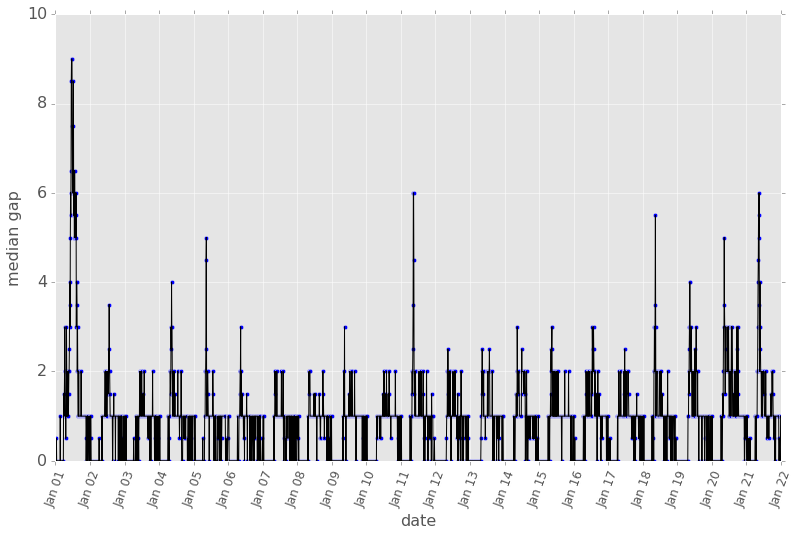

In [23]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(13, 8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.scatter(truetime,timegap['gap'])
ax.plot(truetime,timegap['gap'], c="black")

lox = datetime.datetime.fromtimestamp(1451624400)
hix = max(truetime)
plt.xlim([lox, hix])

plt.ylim([0,10])
plt.ylabel('median district-level gap', size=16)
plt.xlabel('date', size=16)
plt.ylabel('median gap', size=16)
plt.xticks(size=12, rotation=70)
plt.yticks(size=16)

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 9 Text yticklabel objects>)

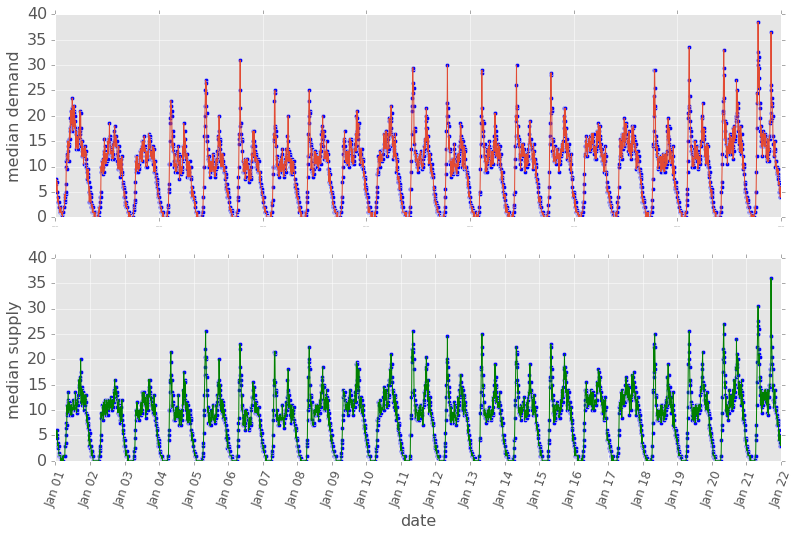

In [24]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(13, 8))
ax = plt.subplot(211)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
#ax.xaxis.set_major_locator(mdates.DayLocator())
ax.scatter(truetime,timegap['demand'])
ax.plot(truetime,timegap['demand'])

lox = datetime.datetime.fromtimestamp(1451624400)
hix = max(truetime)
plt.xlim([lox, hix])

plt.ylim([0,40])
#plt.xlabel('date', size=16)
plt.ylabel('median demand', size=16)
plt.xticks(size=0)
plt.yticks(size=16)

ax = plt.subplot(212)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.scatter(truetime,timegap['supply'])
ax.plot(truetime,timegap['supply'], c="green")

lox = datetime.datetime.fromtimestamp(1451624400)
hix = max(truetime)
plt.xlim([lox, hix])

plt.ylim([0,40])
plt.xlabel('date', size=16)
plt.ylabel('median supply', size=16)
plt.xticks(size=12, rotation=70)
plt.yticks(size=16)

In [25]:
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def test_stationarity(timeseries):
    # copied from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    print dftest
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

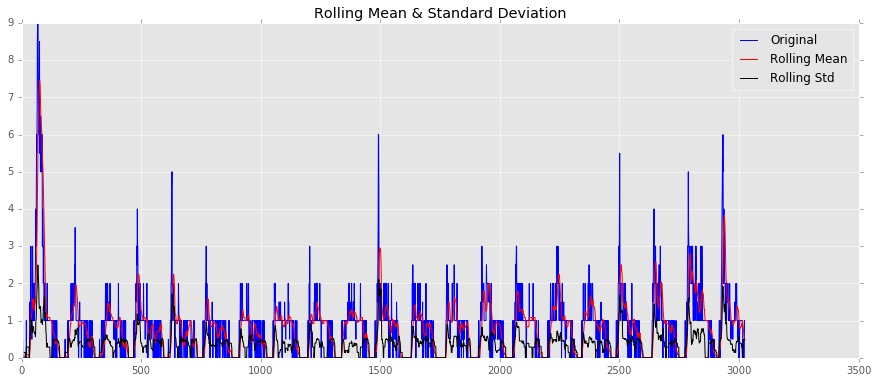

Results of Dickey-Fuller Test:
(-8.24473643160192, 5.5934963152619949e-13, 10, 3013, {'5%': -2.8624997443260951, '1%': -3.4325222137210072, '10%': -2.5672808968779939}, 4031.2627457563731)
Test Statistic                -8.244736e+00
p-value                        5.593496e-13
#Lags Used                     1.000000e+01
Number of Observations Used    3.013000e+03
Critical Value (5%)           -2.862500e+00
Critical Value (1%)           -3.432522e+00
Critical Value (10%)          -2.567281e+00
dtype: float64


In [26]:
test_stationarity(timegap['gap'])

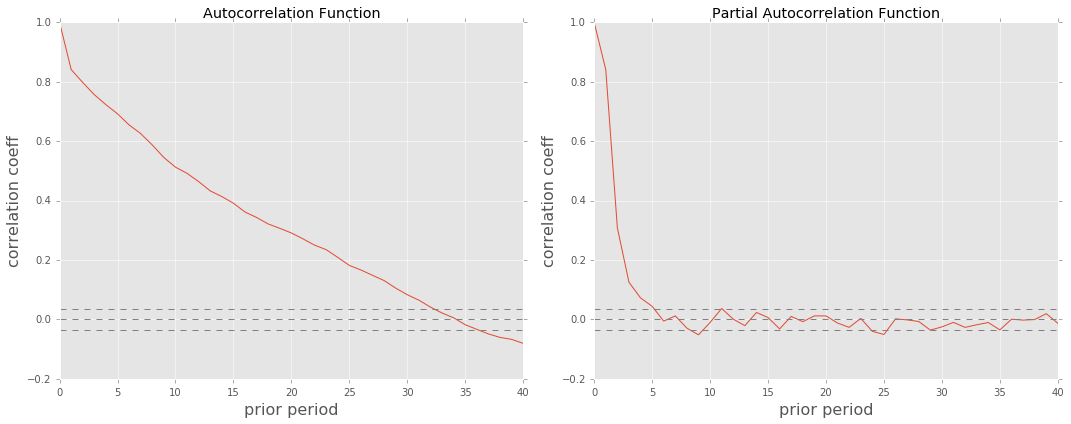

In [28]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(timegap['gap'], nlags=40)
lag_pacf = pacf(timegap['gap'], nlags=40, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(np.shape(timegap)[0]),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(np.shape(timegap)[0]),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('prior period', size=16)
plt.ylabel('correlation coeff', size=16)

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(np.shape(timegap)[0]),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(np.shape(timegap)[0]),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('prior period', size=16)
plt.ylabel('correlation coeff', size=16)
plt.tight_layout()

# Prepare the Data

In [22]:
def get_priors(df, df_2, period, findices, columns):
    df_prior = df_2.copy()
    df_prior['UTC'] = df_prior['UTC'] + period
    df_prior = df_prior[findices+columns]
    df = pd.merge(df, df_prior, on=findices, how='left')
    df = df.rename(columns={col : 'prior%s_%s' % (period, col) for col in columns})
    del df_prior
    return df

In [23]:
def log(df, cols):
    for col in cols:
        df['log_%s' % col] = np.log(df[col]+1)
    return df

In [24]:
def onehot_encode(df, cols):
    return pd.get_dummies(df, columns=cols)

In [25]:
def normalize(df, df_ref, columns):
    for col in columns:
        df[col] = (df[col] - df_ref[col].mean()) / df_ref[col].std()
    return df

In [ ]:
training_data = df_order_train[['district_ID', 'UTC','weekday', 'gap']]
training_data = training_data.rename(columns={'gap' : 'y'})
training_data = pd.merge(training_data, df_poi, on=['district_ID'], how='left')
training_data = (training_data.pipe(get_priors, df_order_train, 1, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 2, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 3, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_traffic_train, 1, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 2, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 3, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_weather_train, 1, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 2, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 3, ['UTC'], 
                                    ['weather', 'pm25', 'temp']))
# incomplete/missing prior period data for the two earliest time intervals
training_data = training_data[training_data['UTC']>3]
training_data.reset_index(drop=True, inplace=True)
loggers = set(training_data.columns).difference(['y', 'district_ID', 'UTC','prior1_weather', 
                                                 'prior2_weather', 'prior3_weather', 'weekday'])
training_data = log(training_data, loggers)
training_data['district'] = training_data['district_ID']
training_data = onehot_encode(training_data, ['prior1_weather', 'prior2_weather', 
                                              'prior3_weather', 'weekday', 'district'])
normalizers = set(training_data.columns).difference(['y', 'district_ID', 'UTC'])
training_data = normalize(training_data, training_data, normalizers)

In [ ]:
training_data.to_csv('TrainingData.csv', index=False)

In [ ]:
training_data.isnull().sum().sort_values(ascending=False)

In [ ]:
training_data.info()

In [ ]:
training_data.head()

In [ ]:
pareto = training_data.corr()['y'].sort_values(ascending=False)[1:]
pareto.plot.bar(figsize=(15, 10))
plt.axhline(0, color='k')
pareto

In [ ]:
training_data=0

In [26]:
training_data4 = df_order_train[['district_ID', 'UTC','weekday', 'gap']]
training_data4 = training_data4.rename(columns={'gap' : 'y'})
training_data4 = pd.merge(training_data4, df_poi, on=['district_ID'], how='left')
training_data4 = (training_data4.pipe(get_priors, df_order_train, 1, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 2, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 3, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 4, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_traffic_train, 1, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 2, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 3, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 4, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_weather_train, 1, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 2, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 3, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 4, ['UTC'], 
                                    ['weather', 'pm25', 'temp']))
# incomplete/missing prior period data for the two earliest time intervals
training_data4 = training_data4[training_data4['UTC']>4]
training_data4.reset_index(drop=True, inplace=True)
loggers = set(training_data4.columns).difference(['y', 'district_ID', 'UTC','prior1_weather', 
                                                 'prior2_weather', 'prior3_weather', 'prior4_weather', 'weekday'])
training_data4 = log(training_data4, loggers)
training_data4['district'] = training_data4['district_ID']
training_data4 = onehot_encode(training_data4, ['prior1_weather', 'prior2_weather', 
                                              'prior3_weather', 'prior3_weather', 'weekday', 'district'])
normalizers = set(training_data4.columns).difference(['y', 'district_ID', 'UTC'])
training_data4 = normalize(training_data4, training_data4, normalizers)

In [27]:
training_data4.to_csv('TrainingData4.csv', index=False)

In [ ]:
training_data5 = df_order_train[['district_ID', 'UTC','weekday', 'gap']]
training_data5 = training_data5.rename(columns={'gap' : 'y'})
training_data5 = pd.merge(training_data5, df_poi, on=['district_ID'], how='left')
training_data5 = (training_data5.pipe(get_priors, df_order_train, 1, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 2, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 3, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 4, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_order_train, 5, ['district_ID', 'UTC'], 
                                    ['demand', 'supply', 'med_price'])
                              .pipe(get_priors, df_traffic_train, 1, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 2, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 3, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 4, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_traffic_train, 5, ['district_ID', 'UTC'], 
                                    ['traffic-1', 'traffic-2', 'traffic-3', 'traffic-4'])
                              .pipe(get_priors, df_weather_train, 1, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 2, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 3, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 4, ['UTC'], 
                                    ['weather', 'pm25', 'temp'])
                              .pipe(get_priors, df_weather_train, 5, ['UTC'], 
                                    ['weather', 'pm25', 'temp']))
# incomplete/missing prior period data for the two earliest time intervals
training_data5 = training_data5[training_data5['UTC']>5]
training_data5.reset_index(drop=True, inplace=True)
loggers = set(training_data5.columns).difference(['y', 'district_ID', 'UTC','prior1_weather', 
                                                 'prior2_weather', 'prior3_weather', 
                                                 'prior4_weather', 'prior5_weather','weekday'])
training_data5 = log(training_data5, loggers)
training_data5['district'] = training_data5['district_ID']
training_data5 = onehot_encode(training_data5, ['prior1_weather', 'prior2_weather', 
                                              'prior3_weather', 'prior4_weather', 
                                              'prior5_weather','weekday', 'district'])
normalizers = set(training_data5.columns).difference(['y', 'district_ID', 'UTC'])
training_data5 = normalize(training_data5, training_data5, normalizers)

In [ ]:
training_data5.to_csv('TrainingData5.csv', index=False)

In [ ]:
pareto5 = training_data5.corr()['y'].sort_values(ascending=False)[1:]
pareto5.plot.bar(figsize=(15, 10))
plt.axhline(0, color='k')
pareto5

In [ ]:
np.shape(training_data5)

In [ ]:
training_data5 = 0

### Storage

### Cleanup

In [ ]:
del df_cluster_map, df_order_train, df_poi, df_traffic_train, df_weather_train